In [1]:
import tensorflow as tf
import awkward as ak
import numpy as np
import glob
import os

2021-07-21 09:40:22.110287: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/nvidia-driver/lib64
2021-07-21 09:40:22.110335: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
data_dir = '/eos/cms/store/group/phys_jetmet/dholmber/jec-dnn'
parquet_dir = os.path.join(data_dir, 'preprocessed/dev')

In [3]:
epochs = 10
loss = 'mean_absolute_error'
optimizer = 'adam'
lr = 1.e-3

activation = 'relu'
initializer = 'he_normal'
batch_norm = False
dropout = 0
units = [128, 128]

train_size = 0.6
test_size = 0.2
val_size = 0.2

In [4]:
jet_numerical = ['pt_log', 'eta', 'mass', 'phi', 'area', 'qgl_axis2', 'qgl_ptD', 'qgl_mult']
jet_categorical = ['puId', 'partonFlavour']

pf_numerical = ['pt', 'eta', 'phi', 'd0', 'dz', 'd0Err', 'dzErr', 'trkChi2', 'vtxChi2', 'puppiWeight', 'puppiWeightNoLep']
pf_categorical = ['charge', 'lostInnerHits', 'pdgId', 'pvAssocQuality', 'trkQuality']

In [5]:
jet_fields = jet_numerical + jet_categorical
pf_fields = pf_numerical + pf_categorical

jet_keys = [f'jet_{field}' for field in jet_fields]
pf_keys = [f'pf_{field}' for field in pf_fields]

num_jet = len(jet_keys)
num_pf = len(pf_keys)

In [6]:
dirs = glob.glob(os.path.join(parquet_dir, '*'))
num_dirs = len(dirs)
train_split = int(train_size * num_dirs)
test_split = int(test_size * num_dirs) + train_split

train_dirs = dirs[:train_split]
test_dirs = dirs[train_split:test_split]
val_dirs = dirs[test_split:]

In [7]:
train_dirs

['/eos/cms/store/group/phys_jetmet/dholmber/jec-dnn/preprocessed/dev/1',
 '/eos/cms/store/group/phys_jetmet/dholmber/jec-dnn/preprocessed/dev/2',
 '/eos/cms/store/group/phys_jetmet/dholmber/jec-dnn/preprocessed/dev/3']

In [8]:
def read_parquet(path):
    path = path.decode()

    jet = ak.from_parquet(os.path.join(path, 'jet.parquet'))
    pf = ak.from_parquet(os.path.join(path, 'pf.parquet'))
    
    row_lengths = ak.num(pf, axis=1)
    flat_pf = ak.flatten(pf, axis=1)
    
    data = [ak.to_numpy(row_lengths).astype(np.int32), ak.to_numpy(jet.target).astype(np.float32)]
    
    for field in jet_fields:
        data.append(ak.to_numpy(jet[field]).astype(np.float32))

    for field in pf_fields:
        data.append(ak.to_numpy(flat_pf[field]).astype(np.float32))
    
    return data

In [9]:
def read_parquet_wrapper(path):
    inp = [path]
    Tout = [tf.int32] + [tf.float32] + [tf.float32] * num_jet + [tf.float32] * num_pf
    
    cols = tf.numpy_function(read_parquet, inp=inp, Tout=Tout)
    
    keys = ['row_lengths'] + ['target'] + jet_keys + pf_keys
    data = {key: value for key, value in zip(keys, cols)}
    
    target = data.pop('target')
    target.set_shape((None,))
    
    row_lengths = data.pop('row_lengths')
    row_lengths.set_shape((None,))
    
    for field in jet_keys:
        # Shape from <unknown> to (None,)
        data[field].set_shape((None,))
        # Shape from (None,) to (None, 1)
        data[field] = tf.expand_dims(data[field], axis=1)
    
    for key in pf_keys:
        # Shape from <unknown> to (None,)
        data[key].set_shape((None,))
        # shape from (None,) to (None, None)
        data[key] = tf.RaggedTensor.from_row_lengths(data[key], row_lengths=row_lengths)
        # Shape from (None, None) to (None, None, 1)
        data[key] = tf.expand_dims(data[key], axis=2)
    
    globals = tf.concat([data[key] for key in jet_keys], axis=1)
    constituents = tf.concat([data[key] for key in pf_keys], axis=2)
    inputs = (constituents, globals)
    
    return inputs, target

In [10]:
def create_dataset(paths):
    ds = tf.data.Dataset.from_tensor_slices(paths)
    ds = ds.map(read_parquet_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.unbatch().batch(256)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [11]:
train_ds = create_dataset(train_dirs).shuffle(64)
val_ds = create_dataset(val_dirs)
test_ds = create_dataset(test_dirs)

2021-07-21 09:40:24.789441: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-21 09:40:24.820867: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-21 09:40:24.821994: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:07.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2021-07-21 09:40:24.822152: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/nvidia-driver/lib64
2021-07-21 09:40:24.822240: W tensorflow/stream_executor/platform/default/dso_lo

In [12]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Activation, Dense, TimeDistributed, BatchNormalization, Dropout, Concatenate, Add
from src.layers import Sum

In [13]:
def get_deepset():
    constituents = Input(shape=(None, num_pf), ragged=True, name='constituents')

    constituents_slice = Input(shape=(constituents.shape[-1],), name='constituents_slice')

    deepset_outputs_slice = mlp(constituents_slice, name='deepset')

    deepset_model_slice = Model(inputs=constituents_slice, outputs=deepset_outputs_slice, name='deepset_model_slice')

    deepset_outputs = TimeDistributed(deepset_model_slice, name='deepset_distributed')(constituents)

    constituents_head = Sum(axis=1, name='constituents_head')(deepset_outputs)

    globals = Input(shape=(num_jet,), name='globals')

    inputs_head = Concatenate(name='head')([constituents_head, globals])

    x = mlp(inputs_head, name='head')

    outputs = Dense(1, name='head_dense_output')(x)

    model = Model(inputs=[constituents, globals], outputs=outputs, name='dnn')

    model.summary()

    for layer in model.layers:
        if isinstance(layer, TimeDistributed):
            layer.layer.summary()

    return model


def mlp(x, name):
    for idx, n in enumerate(units, start=1):
        x = Dense(n, kernel_initializer=initializer, name=f'{name}_dense_{idx}')(x)
        if batch_norm:
            x = BatchNormalization(name=f'{name}_batch_normalization_{idx}')(x)
        x = Activation(activation, name=f'{name}_activation_{idx}')(x)
        if dropout:
            x = Dropout(dropout, name=f'{name}_dropout_{idx}')(x)
    return x

In [14]:
dnn = get_deepset()
dnn.compile(optimizer=optimizer, loss=loss)
dnn.optimizer.lr.assign(lr)

Model: "dnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
constituents (InputLayer)       [(None, None, 16)]   0                                            
__________________________________________________________________________________________________
deepset_distributed (TimeDistri (None, None, 128)    18688       constituents[0][0]               
__________________________________________________________________________________________________
constituents_head (Sum)         (None, 128)          0           deepset_distributed[0][0]        
__________________________________________________________________________________________________
globals (InputLayer)            [(None, 10)]         0                                            
________________________________________________________________________________________________

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.001>

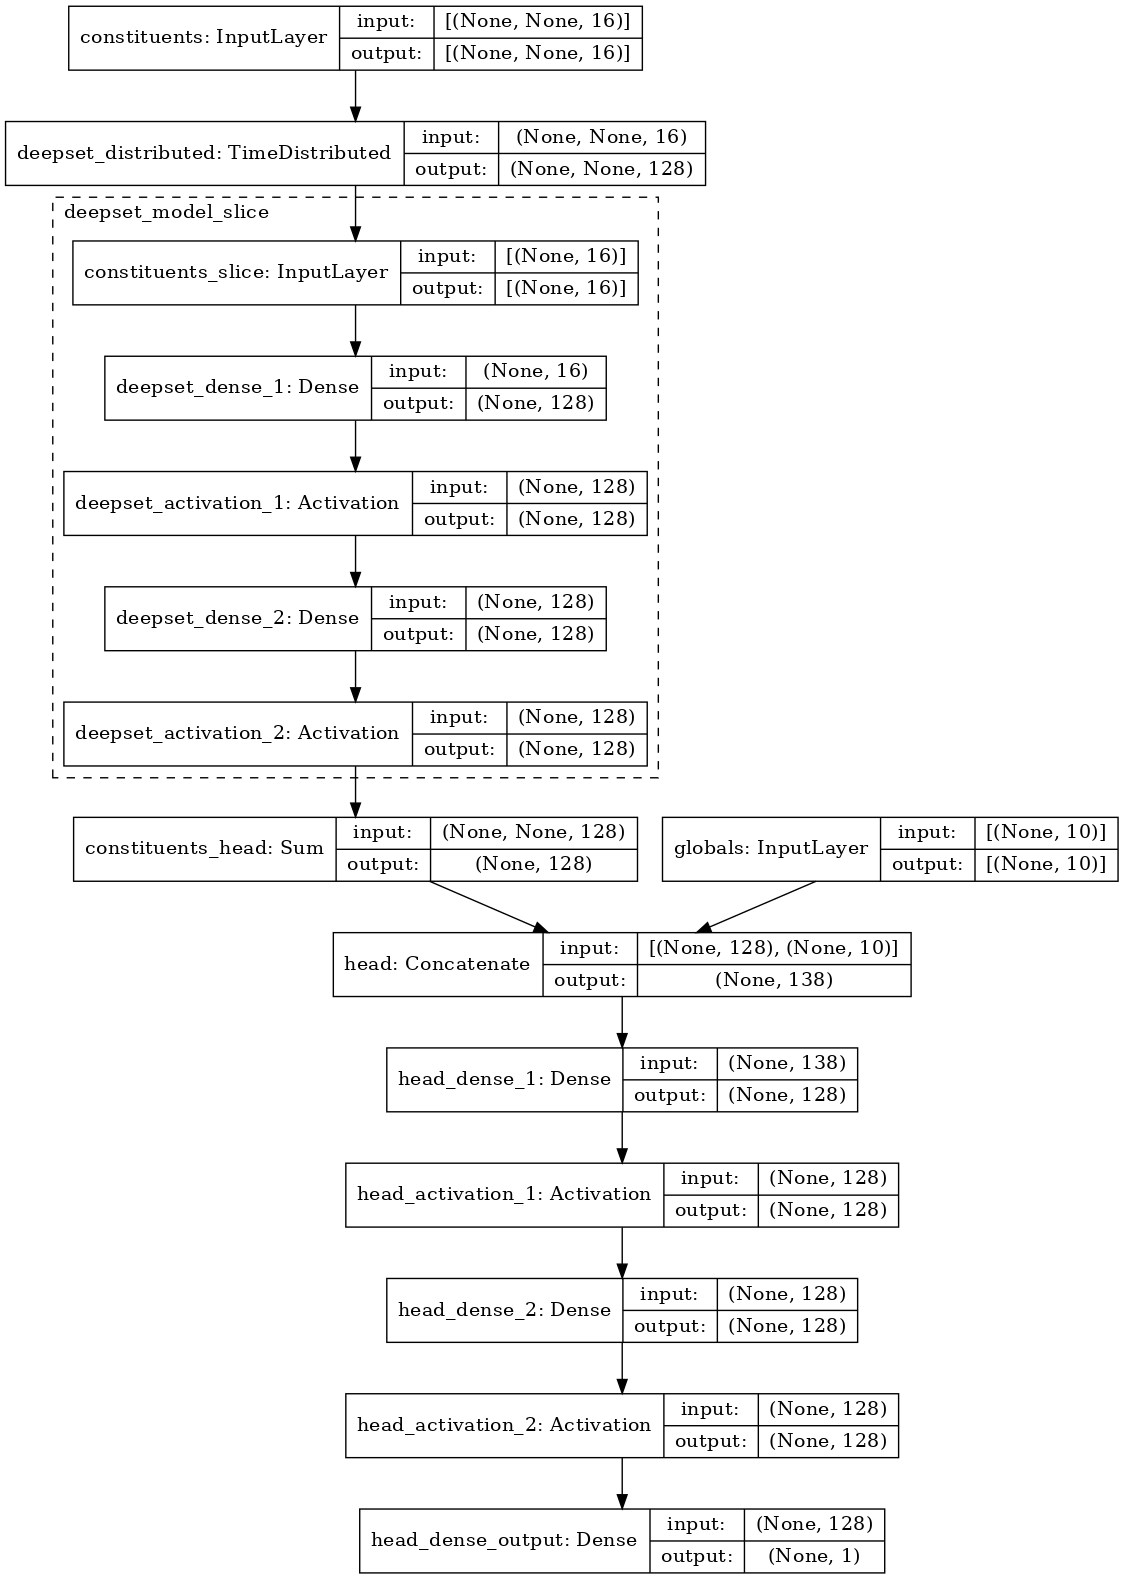

In [15]:
tf.keras.utils.plot_model(dnn, dpi=100, show_shapes=True, expand_nested=True)

In [16]:
fit = dnn.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10


2021-07-21 09:40:28.154308: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-21 09:40:28.157799: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2100175000 Hz


2/2 [==============================] - 2s 804ms/step - loss: 1217.0519 - val_loss: 1647.6951
Epoch 2/10
2/2 [==============================] - 1s 590ms/step - loss: 1823.3959 - val_loss: 671.1218
Epoch 3/10
2/2 [==============================] - 1s 603ms/step - loss: 475.4557 - val_loss: 439.6278
Epoch 4/10
2/2 [==============================] - 1s 598ms/step - loss: 398.0411 - val_loss: 146.0483
Epoch 5/10
2/2 [==============================] - 1s 588ms/step - loss: 215.2148 - val_loss: 98.3515
Epoch 6/10
2/2 [==============================] - 1s 601ms/step - loss: 143.1215 - val_loss: 127.3291
Epoch 7/10
2/2 [==============================] - 1s 603ms/step - loss: 130.0676 - val_loss: 200.2789
Epoch 8/10
2/2 [==============================] - 1s 605ms/step - loss: 193.4228 - val_loss: 167.1424
Epoch 9/10
2/2 [==============================] - 1s 617ms/step - loss: 200.1450 - val_loss: 81.7716
Epoch 10/10
2/2 [==============================] - 1s 607ms/step - loss: 162.0619 - val_loss